📘 Lineares Regressionsmodell zur Umsatzvorhersage

1. 📦 Pakete & Daten laden

In [69]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from workalendar.europe import Germany
import matplotlib.pyplot as plt
from itertools import product


# Datenquellen
base_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/"
df_umsatz = pd.read_csv(base_url + "umsatzdaten_gekuerzt.csv")
df_wetter = pd.read_csv(base_url + "wetter.csv")
df_kiwo = pd.read_csv(base_url + "kiwo.csv")
df_ferien = pd.read_csv("../../data/ferien_sh.csv", parse_dates=["Startdatum", "Enddatum"])


# Alle Datum-Warengruppe-Kombis
alle_daten = pd.date_range(start="2013-07-01", end="2019-07-31", freq="D")
warengruppen = [1, 2, 3, 4, 5, 6]
voll_kombis = pd.DataFrame(list(product(alle_daten, warengruppen)), columns=["Datum", "Warengruppe"])

# Wetterdaten mergen
df_wetter["Datum"] = pd.to_datetime(df_wetter["Datum"])
df = voll_kombis.merge(df_wetter, on="Datum", how="left")

# KiWo
df_kiwo["Datum"] = pd.to_datetime(df_kiwo["Datum"])
df_kiwo["KielerWoche"] = 1
df = df.merge(df_kiwo[["Datum", "KielerWoche"]], on="Datum", how="left").fillna({"KielerWoche": 0})

# Umsatzdaten
df_umsatz["Datum"] = pd.to_datetime(df_umsatz["Datum"])
df = df.merge(df_umsatz, on=["Datum", "Warengruppe"], how="left")
df["Umsatz"] = df["Umsatz"].fillna(0)


# ID
df["id"] = df.apply(lambda row: int(row["Datum"].strftime("%y%m%d") + str(row["Warengruppe"])), axis=1)

# Kalenderfeatures
df["Wochentag"] = df["Datum"].dt.dayofweek
df["Monat"] = df["Datum"].dt.month
df["IstWochenende"] = df["Wochentag"].isin([5, 6]).astype(int)


2. 📅 Feiertage & Ferien ergänzen

In [70]:
cal = Germany(subdivision="SH")
jahre = df['Datum'].dt.year.unique()
feiertage_set = set()
for jahr in jahre:
    feiertage_set.update([d for d, _ in cal.holidays(jahr)])

df['Feiertag'] = df['Datum'].isin(feiertage_set).astype(int)

ferien_tage = set()
for _, row in df_ferien.iterrows():
    ferientage = pd.date_range(start=row['Startdatum'], end=row['Enddatum'])
    ferien_tage.update(ferientage)

df['Ferienzeit'] = df['Datum'].isin(ferien_tage).astype(int)

print(df.dtypes)
print(df.head())

Datum                  datetime64[ns]
Warengruppe                     int64
Bewoelkung                    float64
Temperatur                    float64
Windgeschwindigkeit           float64
Wettercode                    float64
KielerWoche                   float64
id                              int64
Umsatz                        float64
Wochentag                       int32
Monat                           int32
IstWochenende                   int64
Feiertag                        int64
Ferienzeit                      int64
dtype: object
       Datum  Warengruppe  Bewoelkung  Temperatur  Windgeschwindigkeit  \
0 2013-07-01            1         6.0     17.8375                 15.0   
1 2013-07-01            2         6.0     17.8375                 15.0   
2 2013-07-01            3         6.0     17.8375                 15.0   
3 2013-07-01            4         6.0     17.8375                 15.0   
4 2013-07-01            5         6.0     17.8375                 15.0   

   Wetter

/tmp/ipykernel_1896/1852788460.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['Feiertag'] = df['Datum'].isin(feiertage_set).astype(int)


3. 🧼 Fehlende Werte behandeln

#### Wettercode mit kNN

In [ ]:
#df['Wettercode'] = df['Wettercode'].fillna(-1).astype(int)
import numpy as np
from sklearn.impute import KNNImputer

# 0.0 als fehlend markieren
df['Wettercode'] = df['Wettercode'].replace(0.0, np.nan)
print("fehlende Wettercodes vor kNN:", df['Wettercode'].isna().sum())  
fehlende_idx = df[df['Wettercode'].isna()].index
print(fehlende_idx)


# Relevante Features fürs Imputing
knn_features = ['Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Monat']

df_knn = df[['Wettercode'] + knn_features]

# KNN-Imputer anwenden
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = imputer.fit_transform(df_knn)

# Ergebnis zurück in DataFrame schreiben
# Runden und casten zu int, falls Wettercode kategorisch ist
df['Wettercode'] = np.round(df_knn_imputed[:, 0]).astype(int)

print("fehlende Wettercodes nach kNN:", df['Wettercode'].isna().sum())  # sollte 0 sein
fehlende_idx = df[df['Wettercode'].isna()].index
print(fehlende_idx)






fehlende Wettercodes vor kNN: 4452
Index([    6,     7,     8,     9,    10,    11,    24,    25,    26,    27,
       ...
       13286, 13287, 13288, 13289, 13290, 13291, 13292, 13293, 13294, 13295],
      dtype='int64', length=4452)
fehlende Wettercodes nach kNN: 0
Index([], dtype='int64')


In [72]:
df['Temperatur'] = df['Temperatur'].fillna(df['Temperatur'].median())


df['Bewoelkung'] = df['Bewoelkung'].fillna(df['Bewoelkung'].median())
df['Windgeschwindigkeit'] = df['Windgeschwindigkeit'].fillna(df['Windgeschwindigkeit'].median())

#print(df.dtypes)
#print(df.head())
print(df.tail())

           Datum  Warengruppe  Bewoelkung  Temperatur  Windgeschwindigkeit  \
13327 2019-07-31            2         6.0       20.45                  7.0   
13328 2019-07-31            3         6.0       20.45                  7.0   
13329 2019-07-31            4         6.0       20.45                  7.0   
13330 2019-07-31            5         6.0       20.45                  7.0   
13331 2019-07-31            6         6.0       20.45                  7.0   

       Wettercode  KielerWoche       id  Umsatz  Wochentag  Monat  \
13327          61          0.0  1907312     0.0          2      7   
13328          61          0.0  1907313     0.0          2      7   
13329          61          0.0  1907314     0.0          2      7   
13330          61          0.0  1907315     0.0          2      7   
13331          61          0.0  1907316     0.0          2      7   

       IstWochenende  Feiertag  Ferienzeit  
13327              0         0           1  
13328              0      

#### One-Hot Encoding

##### Wettercode

In [73]:
# One-Hot-Encoding für Wettercode mit drop_first=True
wettercode_dummies = pd.get_dummies(df['Wettercode'], prefix='Wettercode', drop_first=True)

# Die Dummy-Spalten an den DataFrame anhängen
df = pd.concat([df, wettercode_dummies], axis=1)

# Die originale Wettercode-Spalte entfernen (falls nicht mehr benötigt)
df.drop('Wettercode', axis=1, inplace=True)

# Beispiel: hole alle Wettercode-Dummy-Spalten
wettercode_cols = [col for col in df.columns if col.startswith('Wettercode_')]

4. ✂️ Datensplit

In [74]:
# Korrigierter Split
train = df[(df['Datum'] >= "2013-07-01") & (df['Datum'] <= "2017-07-31")]
val   = df[(df['Datum'] >= "2017-08-01") & (df['Datum'] <= "2018-07-31")]
test  = df[(df['Datum'] >= "2018-08-01") & (df['Datum'] <= "2019-07-31")]
print(test.shape)
print(test['Datum'].min(), test['Datum'].max())



(2190, 40)
2018-08-01 00:00:00 2019-07-31 00:00:00


In [75]:
print(df['Datum'].max())  # zeigt dir das letzte verfügbare Datum
# Kontrolle
df.isnull().sum()

2019-07-31 00:00:00


Datum                  0
Warengruppe            0
Bewoelkung             0
Temperatur             0
Windgeschwindigkeit    0
KielerWoche            0
id                     0
Umsatz                 0
Wochentag              0
Monat                  0
IstWochenende          0
Feiertag               0
Ferienzeit             0
Wettercode_5           0
Wettercode_10          0
Wettercode_17          0
Wettercode_20          0
Wettercode_21          0
Wettercode_22          0
Wettercode_28          0
Wettercode_29          0
Wettercode_31          0
Wettercode_33          0
Wettercode_41          0
Wettercode_45          0
Wettercode_46          0
Wettercode_49          0
Wettercode_53          0
Wettercode_55          0
Wettercode_61          0
Wettercode_63          0
Wettercode_65          0
Wettercode_68          0
Wettercode_69          0
Wettercode_71          0
Wettercode_73          0
Wettercode_75          0
Wettercode_77          0
Wettercode_79          0
Wettercode_95          0


5. 🤖 Modell trainieren & evaluieren

In [76]:
#1. Variante

import statsmodels.api as sm
import scipy.stats as stats


features = ['Warengruppe', 'Temperatur', 'Bewoelkung', 'Windgeschwindigkeit',
            'KielerWoche', 'Wochentag', 'Monat', 'IstWochenende', 'Feiertag', 'Ferienzeit'] + wettercode_cols
target = 'Umsatz'

model = LinearRegression()
model.fit(train[features], train[target])

preds = model.predict(val[features])
rmse = np.sqrt(mean_squared_error(val[target], preds))
r2 = r2_score(val[target], preds)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")




RMSE: 125.94
R²: 0.182


In [77]:
# 2. Variante

# Nur Temperatur verwenden
X_train = train[["Temperatur"]]
y_train = train["Umsatz"]

# Intercept hinzufügen (statsmodels verlangt expliziten konstanten Term)
X_train = sm.add_constant(X_train)

# Modell trainieren (OLS = Ordinary Least Squares)
model = sm.OLS(y_train, X_train)
results = model.fit()

# Zusammenfassung anzeigen
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     213.8
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           7.08e-48
Time:                        19:28:42   Log-Likelihood:                -57788.
No. Observations:                8952   AIC:                         1.156e+05
Df Residuals:                    8950   BIC:                         1.156e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        133.9123      3.260     41.080      0.0

In [78]:


# One-Hot-Encoding von Warengruppe, Drop First verhindert Multikollinearität
X_train = pd.get_dummies(train[["Temperatur", "KielerWoche", "Warengruppe"]+ wettercode_cols], 
                         columns=["Warengruppe"], drop_first=True)
X_train = X_train.astype(float)
print(X_train.dtypes)
X_train = X_train.astype(float)

# Intercept hinzufügen
X_train = sm.add_constant(X_train)

# Zielvariable
y_train = train["Umsatz"]

# Modell trainieren
model = sm.OLS(y_train, X_train)
results = model.fit()

# Zusammenfassung anzeigen
print(results.summary())









Temperatur       float64
KielerWoche      float64
Wettercode_5     float64
Wettercode_10    float64
Wettercode_17    float64
Wettercode_20    float64
Wettercode_21    float64
Wettercode_22    float64
Wettercode_28    float64
Wettercode_29    float64
Wettercode_31    float64
Wettercode_33    float64
Wettercode_41    float64
Wettercode_45    float64
Wettercode_46    float64
Wettercode_49    float64
Wettercode_53    float64
Wettercode_55    float64
Wettercode_61    float64
Wettercode_63    float64
Wettercode_65    float64
Wettercode_68    float64
Wettercode_69    float64
Wettercode_71    float64
Wettercode_73    float64
Wettercode_75    float64
Wettercode_77    float64
Wettercode_79    float64
Wettercode_95    float64
Warengruppe_2    float64
Warengruppe_3    float64
Warengruppe_4    float64
Warengruppe_5    float64
Warengruppe_6    float64
dtype: object


                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     863.3
Date:                Tue, 01 Jul 2025   Prob (F-statistic):               0.00
Time:                        19:28:42   Log-Likelihood:                -52267.
No. Observations:                8952   AIC:                         1.046e+05
Df Residuals:                    8925   BIC:                         1.048e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            71.4700      3.539     20.196

🟦 1. Visualisierung: Vorhergesagt vs. Tatsächlich

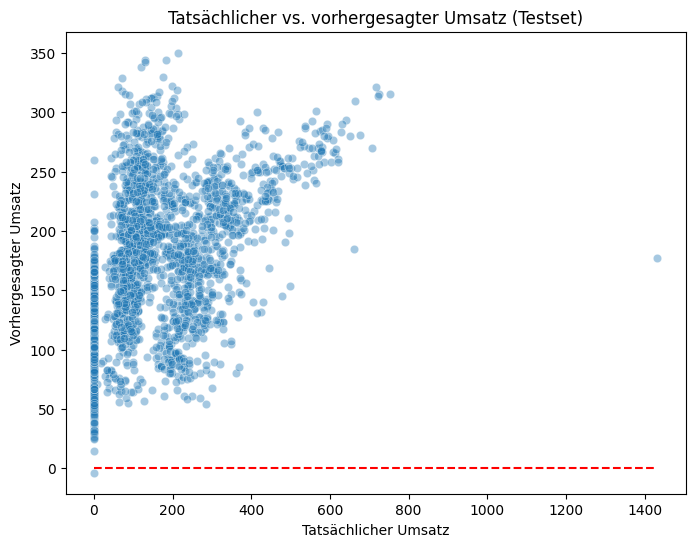

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=val[target], y=preds, alpha=0.4)
plt.xlabel("Tatsächlicher Umsatz")
plt.ylabel("Vorhergesagter Umsatz")
plt.title("Tatsächlicher vs. vorhergesagter Umsatz (Testset)")
plt.plot([0, val[target].max()], [0, test[target].max()], color='red', linestyle='--')  # Diagonale
plt.show()

🟨 2. Einfluss der Merkmale (Koeffizienten)

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

# Dummy-Spalten des Wettercodes finden
wettercode_cols = [col for col in coeffs.index if col.startswith('Wettercode_')]

# Durchschnitt der absoluten Koeffizienten der Wettercode-Dummies
wettercode_influence = coeffs[wettercode_cols].abs().mean()

# Koeffizienten ohne Wettercode-Dummies
other_coeffs = coeffs.drop(wettercode_cols)

# Neue Series mit aggregiertem Wettercode-Einfluss
wettercode_series = pd.Series({'Wettercode gesamt': wettercode_influence})

# Zusammenfügen mit concat
combined_coeffs = pd.concat([other_coeffs, wettercode_series])

# Sortieren für bessere Visualisierung
combined_coeffs = combined_coeffs.sort_values()

# Plot
combined_coeffs.plot(kind='barh', figsize=(8,5), title='Einfluss der Merkmale (Wettercode aggregiert)')
plt.xlabel('Absoluter Koeffizient (Durchschnitt Wettercode-Dummies)')
plt.tight_layout()
plt.show()





'''
coeffs = pd.Series(model.coef_, index=features)
coeffs.sort_values(ascending=False).plot(kind="barh", figsize=(8, 5), title="Einfluss der Merkmale")
plt.xlabel("Koeffizient")
plt.tight_layout()
plt.show()'''

NameError: name 'coeffs' is not defined